In [1]:
import numpy as np
from subprocess import call
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from math import isnan

In [2]:
def get_matrix(pi1, pi2, q1, q2, l, sol_index=1):
    '''
    sol_index=1: the program that finds the solution always gets the good one on the second row of the file (when verbosity -v)
    '''
    r1, r2 = 1/q1, 1/q2
    # first get the stationary f0:
    call(f'python f0poly_sols_clean.py {pi1} {pi2} {q1} {q2} {l} -v > sols.dat', shell=True)
    sols = []
    with open('sols.dat', 'r') as file:
        for line in file.readlines():
            sols_i = [float(f) for f in line.split()]
            sols.append(sols_i)
    f0 = sols[sol_index][0] 
    a11 = l*f0-r1-(1-l)*pi1*(1+l/(r1/f0-l))
    a12 = -pi1*(1-l)*(1+l/(r1/f0-l))
    a21 = -pi2*(1-l)*(1+l/(r2/f0-l))
    a22 = l*f0-r2-(1-l)*pi2*(1+l/(r2/f0-l))
    a = np.array([[a11,a12], [a21, a22]])
    return a

def get_matrix_sol_spec(pi1, pi2, q1, q2, l, f0):
    '''
    provide the values of f0
    '''
    r1, r2 = 1/q1, 1/q2
    a11 = l*f0-r1-(1-l)*pi1*(1+l/(r1/f0-l))
    a12 = -pi1*(1-l)*(1+l/(r1/f0-l))
    a21 = -pi2*(1-l)*(1+l/(r2/f0-l))
    a22 = l*f0-r2-(1-l)*pi2*(1+l/(r2/f0-l))
    a = np.array([[a11,a12], [a21, a22]])
    return a

In [9]:
# pi1, pi2, q1, q2, l = 0.00001, 0.00001, 10, 10, 0.05
pi1, pi2, q1, q2, l = 0.0, 0.0, 7, 10, 0.5
a = get_matrix(pi1, pi2, q1, q2, l, sol_index=0)
print(np.linalg.eig(a)[0])
eigs = np.linalg.eig(a)[0]

a = get_matrix(pi1, pi2, q1, q2, l, sol_index=1)
print(np.linalg.eig(a)[0])
eigs = np.linalg.eig(a)[0]

a = get_matrix(pi1, pi2, q1, q2, l, sol_index=2)
print(np.linalg.eig(a)[0])
eigs = np.linalg.eig(a)[0]

# a = get_matrix_sol_spec(pi1, pi2, q1, q2, l, f0=0.1)
# print(np.linalg.eig(a)[0])
# eigs = np.linalg.eig(a)[0]

[0.35714286 0.4       ]
[-4.28571429e-02 -1.38777878e-16]
[1.11022302e-16 4.28571429e-02]


In [ ]:
np.linalg.eig(a)[1][:,0]

In [ ]:
1/eigs[1]**2

## f0 stability case q1=q2, pi1=pi2

In [ ]:
def stability_f0_eq_1(p, q, l):
    r = 1/q
    try:
        func = l-r+2*p*(1-l)*(l+r)/(l-r)
    except ZeroDivisionError:
        print(f'Divide by 0 encountered when p, q, l: {p}, {q}, {l}')
        func = 0.0
    return func

def stability_f0_eq_roverl(p, q, l):
    r = 1/q
    func = -(l-r+2*p*(1-l)*(l+r)/(l-r))
    return func


def stability_f0_eq_1_eps(eps, q, l):
    r = 1/q
    func = l-r+2*eps*(l+r)/(l-r)
    return func

In [ ]:
# explore a renge of pi's, lambdas:
q = 10
pi_lims = (0.0, 0.2)
Npis = 21
l_lims = (0.0, 2/q)
Nls = 21
xgrid_pi, ygrid_l = np.mgrid[pi_lims[0]:pi_lims[1]:complex(0,Npis), l_lims[0]:l_lims[1]:complex(0,Nls)]
xgrid_pi, ygrid_l = np.around(xgrid_pi,4), np.around(ygrid_l,4)
grid_stability = np.empty([Npis, Nls])
for i,pi in enumerate(xgrid_pi[:,0]):
    for j,l in enumerate(ygrid_l[0,:]):
        fstab = stability_f0_eq_1(pi, q, l)
        # if l == 0.1:
        #     print(fstab)
        if fstab == 0.0 or fstab == np.inf or isnan(fstab):
            # print(f'aaaaay: pi = {pi}, l = {l}')
            grid_stability[i,j] = 2 # cumbersome
        elif (fstab < 0):
            grid_stability[i,j] = 1 # stable
        elif (fstab > 0):
            grid_stability[i,j] = 0 # unstable
        # else:
        #     print(f'aaaaay: pi = {pi}, l = {l}')
        #     print(fstab)
        #     grid_stability[i,j] = 2 # cumbersome

In [ ]:
mycmap = ListedColormap(['xkcd:red', 'xkcd:green', 'xkcd:black']) # 0: red, unstable; 1: green, stable
fig, ax = plt.subplots()
im = ax.pcolormesh(xgrid_pi, ygrid_l, grid_stability, vmin=0, vmax=2, cmap=mycmap, shading='nearest')
ax.set(xlabel='$\pi_{1,2}$', ylabel='$\lambda$')

In [ ]:
# explore a renge of epsilon, lambdas:
q = 10
eps_lims = (0.0, 0.001)
Neps = 21
l_lims = (0.0, 2/q)
Nls = 21
xgrid_eps, ygrid_l = np.mgrid[eps_lims[0]:eps_lims[1]:complex(0,Neps), l_lims[0]:l_lims[1]:complex(0,Nls)]
xgrid_eps, ygrid_l = np.around(xgrid_eps,4), np.around(ygrid_l,4)
grid_stability = np.empty([Neps, Nls])
for i,eps in enumerate(xgrid_eps[:,0]):
    for j,l in enumerate(ygrid_l[0,:]):
        fstab = stability_f0_eq_1_eps(eps, q, l)
        # if l == 0.1:
        #     print(fstab)
        if fstab == 0.0 or fstab == np.inf or isnan(fstab):
            # print(f'aaaaay: pi = {pi}, l = {l}')
            grid_stability[i,j] = 2 # cumbersome
        elif (fstab < 0):
            grid_stability[i,j] = 1 # stable
        elif (fstab > 0):
            grid_stability[i,j] = 0 # unstable
        # else:
        #     print(f'aaaaay: pi = {pi}, l = {l}')
        #     print(fstab)
        #     grid_stability[i,j] = 2 # cumbersome

In [ ]:
mycmap = ListedColormap(['xkcd:red', 'xkcd:green', 'xkcd:black']) # 0: red, unstable; 1: green, stable
fig, ax = plt.subplots()
im = ax.pcolormesh(xgrid_eps, ygrid_l, grid_stability, vmin=0, vmax=2, cmap=mycmap, shading='nearest')
ax.set(xlabel='$\epsilon$', ylabel='$\lambda$')

In [ ]:
q, l = 10, 0.05
eps = np.linspace(0.0, 0.1, 50)
fig, ax = plt.subplots()

stab = [stability_f0_eq_1_eps(e, q, l) for e in eps]

ax.plot(eps, stab)
    

# Eigenvalues as characteristic times

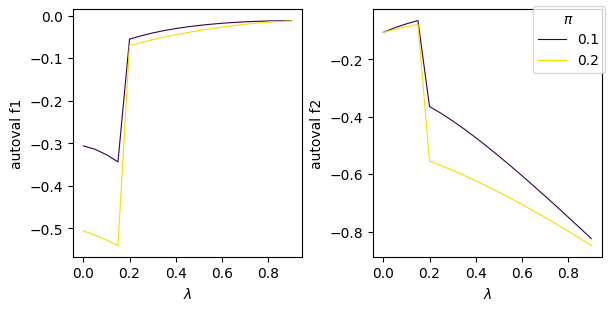

In [28]:
q1, q2 = 9, 10
ls = np.linspace(0.0, 0.9, 19)
pis = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
pis = [0.1, 0.2]
pis_colors = plt.cm.gnuplot(np.linspace(0.05, 0.95, len(pis)))

fig, ax = plt.subplots(1,2, figsize=(6,3), constrained_layout=True)
ax[0].set(xlabel='$\lambda$', ylabel='autoval f1')
ax[1].set(xlabel='$\lambda$', ylabel='autoval f2')
for p,c in zip(pis, pis_colors):
    avals_f1, avals_f2 = [], []
    for l in ls:
        if l == 0.0:
            mat = get_matrix_sol_spec(p, p, q1, q2, l, 1/(1+p*q1+p*q2))
        else:
            mat = get_matrix(p, p, q1, q2, l, sol_index=1)
        eigs = np.linalg.eig(mat)[0]
        # avals_f1.append(1/abs(eigs[0]))
        # avals_f2.append(1/abs(eigs[1]))
        avals_f1.append(eigs[0])
        avals_f2.append(eigs[1])
    ax[0].plot(ls, avals_f1, label=f'{p}', lw=0.8, color=c)
    ax[1].plot(ls, avals_f2, lw=0.8, color=c)

fig.legend(title='$\pi$')

In [24]:
pi1, pi2, q1, q2, l = 0.1, 0.1, 9, 10, 0.8
a = get_matrix(pi1, pi2, q1, q2, l, sol_index=1)
print(np.linalg.eig(a)[0])
eigs = np.linalg.eig(a)[0]

[-0.01218212 -0.74909617]


In [22]:
1/eigs[0]

-3.187915980437617